<a href="https://colab.research.google.com/github/areias/bert_covid_sentiment/blob/main/MasterProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import packages

In [ ]:
from IPython.display import clear_output

!pip install transformers
!pip install wandb

clear_output()

In [ ]:
from datetime import datetime
import wandb
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import (
    AutoConfig,
    AutoTokenizer,
    TFAutoModelForSequenceClassification,
    AdamW,
    glue_convert_examples_to_features
)
import tensorflow as tf
import json

In [ ]:
class Training:

    def __init__(self, name, project_name, folder_name, learning_rate):
        self.model_name = 'digitalepidemiologylab/covid-twitter-bert-v2'
        self.wandb = wandb 
        self.wandb.init(name=name, project=project_name)
        self.folder_name = folder_name
        self.learning_rate = learning_rate
        self.set_model()

    def set_model(self):
        # Grab config & model
        config = AutoConfig.from_pretrained(self.model_name, num_labels=3)
        self.model = TFAutoModelForSequenceClassification.from_pretrained(self.model_name, config=config)

        # Optimizer and loss
        optimizer = tf.keras.optimizers.Adam(
                                             init_lr=3e-5,
                                          num_train_steps=17010,
                                          num_warmup_steps=int(17010*0.1),)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        # Metrics and callbacks
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
        checkpoint_path = './checkpoints/checkpoint.{epoch:02d}'
        callbacks = [tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True)]

        # Compile model
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


    def tokenize(self, data):
        tokenizer = AutoTokenizer.from_pretrained(self.model_name, normalization=True)
        tokens = []
        for t in data['text']:
            tokens.append(tokenizer.encode(t))

        tokens_padded = pad_sequences(tokens)
        return np.array(tokens_padded)
    
    def get_labels(self, data):
        labels = []
        for l in data['label']:
            if (l == -1):
                labels.append(0)
            elif (l == 0):
                labels.append(1)
            elif (l == 1):
                labels.append(2)
        return np.array(labels)

    def preprocess(self, data):
        tokenizer = AutoTokenizer.from_pretrained(self.model_name, normalization=True)
        tokens = []
        for t in data['text']:
            tokens.append(tokenizer.encode(t))

        tokens_padded = pad_sequences(tokens)
        labels = []
        for l in data['label']:
            if (l == -1):
                labels.append(0)
            elif (l == 0):
                labels.append(1)
            elif (l == 1):
                labels.append(2)
        X = np.array(tokens_padded)
        Y = np.array(labels)

        return X, Y

    def save_model(self):
        self.model.save_pretrained(self.folder_name)
        self.tokenizer.save_pretrained(self.folder_name)

    def predict(self, data):
        X = self.tokenize(data)

        hyp = self.model.predict(X)
        l1 = tf.nn.softmax(hyp.logits, axis=0)
        l2 = tf.nn.softmax(hyp.logits, axis=1)
        rs = tf.reduce_sum([l1, l2], 0)
        preds = []
        for r in rs:
          preds.append(np.argmax(r))

        return preds

    def train_model(self, data, num_epochs, bs):

        X = self.tokenize(data)
        Y = self.get_labels(data)
        self.num_epochs = num_epochs

        # Train the model
        history = self.model.fit(init_lr=init_lr, x=X, y=Y, epochs=num_epochs, batch_size=bs)

        for each in range(len(history.history["loss"])):
          wandb.log({
          "Epoch": each+1,
          "Optimizer":"Adam",
          "loss": "SparseCategoricalCrossentropy",
          "Train Acc": history.history["accuracy"][each],
          "Valid Loss": history.history["loss"][each],})

        return history

wandb: Currently logged in as: kuul-guy (use `wandb login --relogin` to force relogin)


Epoch,▁▃▅▆█
Train Acc,▆█▁▄▆
Valid Loss,▄▇▆█▁
Epoch,5
Optimizer,Adam
Train Acc,0.33333
Valid Loss,9.03234
loss,SparseCategoricalCro...


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: ignored

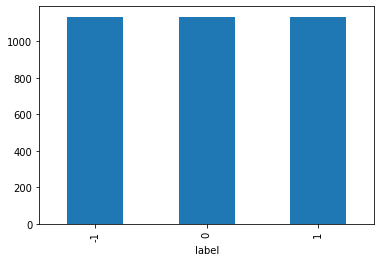

In [ ]:
!wandb login

data = pd.read_csv('train.csv', lineterminator='\n')

# input data split
data.groupby(['label']).size().plot(kind = 'bar')

data = data[['text', 'label']]
t = data

train_x, test_x, train_y, test_y = train_test_split(data[['text']], data[['label']], test_size=0.2, random_state=42)

train_x["label"] = train_y["label"]
train = train_x
test_x["label"] = test_y["label"]
test = test_x
bs1 = 8
lr = 0.01
a = Training(name="MastersProject-Adadelta-LR-"+str(lr), project_name="covid-analysis", folder_name="./saved_model", learning_rate=lr)
x = a.train_model(data=train,
                  num_epochs=5,
                  bs=bs1)
lr = 0.001
a = Training(name="MastersProject-Adadelta-LR-"+str(lr), project_name="covid-analysis", folder_name="./saved_model", learning_rate=lr)
x = a.train_model(data=train,
                  num_epochs=5,
                  bs=bs1)
lr = 0.02
a = Training(name="MastersProject-Adadelta-LR-"+str(lr), project_name="covid-analysis", folder_name="./saved_model", learning_rate=lr)
x = a.train_model(data=train,
                  num_epochs=5,
                  bs=bs1)
lr = 0.002
a = Training(name="MastersProject-Adadelta-LR-"+str(lr), project_name="covid-analysis", folder_name="./saved_model", learning_rate=lr)
x = a.train_model(data=train,
                  num_epochs=5,
                  bs=bs1)
lr = 0.03
a = Training(name="MastersProject-Adadelta-LR-"+str(lr), project_name="covid-analysis", folder_name="./saved_model", learning_rate=lr)
x = a.train_model(data=train,
                  num_epochs=5,
                  bs=bs1)
lr = 0.003
a = Training(name="MastersProject-Adadelta-LR-"+str(lr), project_name="covid-analysis", folder_name="./saved_model", learning_rate=lr)
x = a.train_model(data=train,
                  num_epochs=5,
                  bs=bs1)

lr = 0.1
a = Training(name="MastersProject-Adadelta-LR-"+str(lr), project_name="covid-analysis", folder_name="./saved_model", learning_rate=lr)
x = a.train_model(data=train,
                  num_epochs=5,
                  bs=bs1)
lr = 0.05
a = Training(name="MastersProject-Adadelta-LR-"+str(lr), project_name="covid-analysis", folder_name="./saved_model", learning_rate=lr)
x = a.train_model(data=train,
                  num_epochs=5,
                  bs=bs1)

In [ ]:
a1 = Training(name="MastersProject1", project_name="covid-analysis", folder_name="./saved_model", learning_rate=0.01)
qw = a1.predict(train[["text"]])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


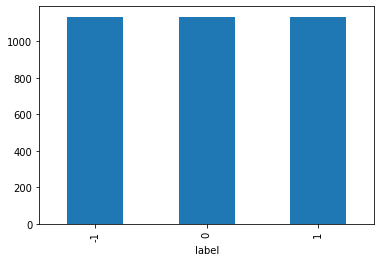

In [ ]:
data = pd.read_csv('train.csv', lineterminator='\n')

# input data split
data.groupby(['label']).size().plot(kind = 'bar')


In [ ]:
qw1 = a1.get_labels(train[["label"]])

In [ ]:
y = a.predict(train[["text"]])

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(a.get_labels(train[["label"]]), y)

array([[744,   0,   0],
       [752,   0,   0],
       [745,   0,   0]])

In [ ]:
set(y)

{0}

In [ ]:
w = pd.read_csv('train-2.csv', lineterminator='\n')

In [ ]:
w.groupby(['label']).size()

label
-1    1134
 0    6467
 1    4464
dtype: int64

In [ ]:
a = w[w["label"] == 0].sample(1134)
b = w[w["label"] == 1].sample(1134)
c = w[w["label"] == -1].sample(1134)


In [ ]:
a

,Unnamed: 0,tweet_id,text,label
678,678,588567851256061953,@jesse_holbrook of course it's @ap.. measles '...,0
594,594,562433759283122177,@Mad_Science_Guy recall the X Files ep where t...,0
11692,11692,430056573713797120,Herd Immunity people #science RT @timesunion: ...,0
11444,11444,365436743429791745,Officials: Michigan's vaccination rates are dr...,0
2499,2499,680153818508693504,Bring it on typhoid fever !! And all the other...,0
...,...,...,...,...
7926,7926,472435251793260544,New vaccinations required for Maryland student...,0
597,597,562436750786977792,@allinwithchris Measles McCarthy and now Rub...,0
4142,4142,747479571688087552,AIDS N : Could mimicking infants' immune respo...,0
3146,3146,132675523972308992,"go right through you like Brandreth's pills, r...",0


In [ ]:
d = pd.concat([a, b, c], ignore_index=True)[["tweet_id", "text", "label"]]

In [ ]:
d.to_csv("train.csv")

In [ ]:
pd.read_csv("train.csv" , lineterminator='\n')

,Unnamed: 0,tweet_id,text,label
0,0,563451548471005184,Businesses forced to deal with measles as it m...,0
1,1,676899944708579329,Have you ever wondered what's really in a vacc...,0
2,2,231600872134672384,Autism researcher Wakefield cana t sue UK jour...,0
3,3,463400252100198400,“@HuffingtonPost: The spread of polio is offic...,0
4,4,350414898389467137,I don't get why when I ask. My mom if i can g...,0
...,...,...,...,...
3397,3397,543200653825556480,#autism # vaccine # family # FAITH WE NEED YOU...,-1
3398,3398,295083865968627713,My baby got a painful lump on her back leg fro...,-1
3399,3399,373629025182580736,"7. Protect the Children - Don't Vaccinate, Med...",-1
3400,3400,563132764271038464,@mission2heal Do the statistics back up the cl...,-1
